In [0]:
a = []
while(1):
    a.append('1')

In [0]:
!pip install -U -q kaggle
!mkdir ~/.kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikunjgoel","key":"4d4b8ceb591a64c1ae4e80996446b150"}'}

In [0]:
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c 11-785-s20-hw1p2

  0% 0.00/381k [00:00<?, ?B/s]
100% 381k/381k [00:00<00:00, 52.9MB/s]
100% 8.40M/8.40M [00:00<00:00, 64.9MB/s]

 95% 73.0M/76.8M [00:00<00:00, 63.9MB/s]
100% 76.8M/76.8M [00:00<00:00, 131MB/s] 
100% 5.16G/5.17G [01:42<00:00, 58.9MB/s]
100% 5.17G/5.17G [01:42<00:00, 53.9MB/s]
 97% 225M/232M [00:08<00:00, 36.3MB/s]
100% 232M/232M [00:08<00:00, 29.8MB/s]
  0% 0.00/756k [00:00<?, ?B/s]
100% 756k/756k [00:00<00:00, 239MB/s]


In [0]:
import numpy as np
trainingFilePath = "/content/train.npy.zip"
data_train = np.load(trainingFilePath,encoding = 'bytes',allow_pickle = True)['train']

In [0]:
trainingLabelFilePath = "/content/train_labels.npy.zip"
data_train_label = np.load(trainingLabelFilePath,encoding = 'bytes',allow_pickle = True)['train_labels']

In [0]:
import numpy as np
testingFilePath = "/content/test.npy.zip"
data_test = np.load(testingFilePath,encoding = 'bytes',allow_pickle = True)['test']

In [0]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import time

In [0]:
cuda = torch.cuda.is_available()
cuda

True

In [0]:
class MyDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(np.vstack(X))
        self.Y = torch.from_numpy(np.vstack(np.array([np.expand_dims(i,axis=1) for i in Y]))).reshape(self.X.shape[0],)
        self.frameIndex = dict()
        counter = 0
        for i in range(X.shape[0]):
          for j in range(X[i].shape[0]):
            if j < 12:
              self.frameIndex[counter] = j - 12
            elif j >= (X[i].shape[0] - 12):
              self.frameIndex[counter] =  13 - (X[i].shape[0] - j)
            else:
              self.frameIndex[counter] = 0
            counter = counter + 1 

    def __len__(self):
        return len(self.frameIndex)

    def __getitem__(self,index):
        frame = self.frameIndex[index]
        if frame < 0:
          X = torch.cat((torch.zeros(abs(frame)*40,dtype=torch.float64),torch.flatten(self.X[index - (12 - abs(frame)):index+13])),0)
          Y = self.Y[index].long()
        elif frame>0:
          X = torch.cat((torch.flatten(self.X[index-12:index+(13-frame)]),torch.zeros(frame*40,dtype=torch.float64)),0)
          Y = self.Y[index].long()
        else:
          X = torch.flatten(self.X[index-12:index+13])
          Y = self.Y[index].long()
        return X.float(),Y



In [0]:
# class MyDataset(data.Dataset):
#     def __init__(self, X, Y):
#         self.X = torch.from_numpy(np.vstack(X))
#         self.Y = torch.from_numpy(np.vstack(np.array([np.expand_dims(i,axis=1) for i in Y]))).reshape(self.X.shape[0],)

#     def __len__(self):
#         self.data_ln = len(self.Y)
#         return len(self.Y)

#     def __getitem__(self,index):
#         if index < 12:
#           X = torch.cat((torch.zeros((12-index)*40,dtype=torch.float64),torch.flatten(self.X[0:index+13])),0)
#           Y = self.Y[index].long()
#         elif index >= (self.data_ln - 12):
#           X = torch.cat((torch.flatten(self.X[index-12:self.data_ln]),torch.zeros((13 - (self.data_ln - index))*40,dtype=torch.float64)),0)
#           Y = self.Y[index].long()
#         else:
#           X = torch.flatten(self.X[index-12:index+13])
#           Y = self.Y[index].long()
#         return X.float(),Y



In [0]:
class MyDatasetTest(data.Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(np.vstack(X))
        # self.Y = torch.from_numpy(np.vstack(np.array([np.expand_dims(i,axis=1) for i in Y]))).reshape(self.X.shape[0],)
        self.frameIndex = dict()
        counter = 0
        for i in range(X.shape[0]):
          for j in range(X[i].shape[0]):
            if j < 12:
              self.frameIndex[counter] = j - 12
            elif j >= (X[i].shape[0] - 12):
              self.frameIndex[counter] =  13 - (X[i].shape[0] - j)
            else:
              self.frameIndex[counter] = 0
            counter = counter + 1 

    def __len__(self):
        return len(self.frameIndex)

    def __getitem__(self,index):
        frame = self.frameIndex[index]
        if frame < 0:
          X = torch.cat((torch.zeros(abs(frame)*40,dtype=torch.float64),torch.flatten(self.X[index - (12 - abs(frame)):index+13])),0)
          # Y = self.Y[index].long()
        elif frame>0:
          X = torch.cat((torch.flatten(self.X[index-12:index+(13-frame)]),torch.zeros(frame*40,dtype=torch.float64)),0)
          # Y = self.Y[index].long()
        else:
          X = torch.flatten(self.X[index-12:index+13])
          # Y = self.Y[index].long()
        return X.float()



In [0]:
# class MyDatasetTest(data.Dataset):
#     def __init__(self, X):
#         self.X = torch.from_numpy(np.vstack(X))

#     def __len__(self):
#         self.lengthofData = len(self.X)
#         return len(self.X)

#     def __getitem__(self,index):
#         if index < 12:
#           X = torch.cat((torch.zeros((12-index)*40,dtype=torch.float64),torch.flatten(self.X[0:index+13])),0)
#         elif index >= (len(self.X) - 12):
#           X = torch.cat((torch.flatten(self.X[index-12:len(self.X)]),torch.zeros((13 - (len(self.X) - index))*40,dtype=torch.float64)),0)
#         else:
#           X = torch.flatten(self.X[index-12:index+13])
#         return X.float()

In [0]:
# Training
train_dataset = MyDataset(data_train, data_train_label)

train_loader_args = dict(shuffle=True, batch_size=128, num_workers=8, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=64)
train_loader = data.DataLoader(train_dataset, **train_loader_args)


In [0]:
test_dataset = MyDatasetTest(data_test)

test_loader_args = dict(shuffle=False, batch_size=128, num_workers=8, pin_memory=True) if cuda\
                    else dict(shuffle=False, batch_size=1)
test_loader = data.DataLoader(test_dataset, **test_loader_args)

In [0]:
testCounter = 0;
for batch, (data,target) in enumerate(train_loader):
  print(data.shape, target.shape)
  testCounter = testCounter + 1
  if testCounter == 15:
    break

torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])
torch.Size([128, 1000]) torch.Size([128])


In [0]:
cuda

True

In [0]:
# SIMPLE MODEL DEFINITION
class Simple_MLP(nn.Module):
    def __init__(self, size_list):
        super(Simple_MLP, self).__init__()
        layers = []
        self.size_list = size_list
        # print(size_list)
        # print(len(size_list) - 2)
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.BatchNorm1d(size_list[i+1]))
            layers.append(nn.LeakyReLU())
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)



In [0]:
model = Simple_MLP([1000,2048,1024,1024,1024,1024,800,512,138])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=1000, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative

In [0]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()
        if (batch_idx%10000) == 0:
              print(batch_idx,' Running Loss ',running_loss)
        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [0]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        output = []
        counter = 0
        for batch_idx, (data) in enumerate(test_loader):   
            data = data.to(device)
            # target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            ansB = predicted.cpu().numpy()
            for i in range(ansB.shape[0]):
              output.append((counter,ansB[i]))
              counter = counter + 1
            # numpyPred = np.array(predicted.cpu)
            # for i in range(numpyPred.shape[0]):
            #   outPutList.append(counter,numpyPred[i])
            #   counter = counter + 1
            # total_predictions += target.size(0)
            # correct_predictions += (predicted == target).sum().item()

            # loss = criterion(outputs, target).detach()
            # running_loss += loss.item()
            

        # running_loss /= len(test_loader)
        # acc = (correct_predictions/total_predictions)*100.0
        # print('Testing Loss: ', running_loss)
        # print('Testing Accuracy: ', acc, '%')
        # return running_loss, acc
        return np.array(output)


In [0]:
n_epochs = 25
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    # test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    #Test_loss.append(test_loss)
    #Test_acc.append(test_acc)
    print('='*20)

0  Running Loss  4.97443151473999
1000  Running Loss  3386.9752066135406
2000  Running Loss  6385.580970048904
3000  Running Loss  9216.506766319275
4000  Running Loss  11964.478477478027
5000  Running Loss  14644.336750030518
6000  Running Loss  17293.213108301163
7000  Running Loss  19877.387897729874
8000  Running Loss  22430.90770292282
9000  Running Loss  24940.232793569565
10000  Running Loss  27412.960919618607
11000  Running Loss  29863.879643321037
12000  Running Loss  32293.970700621605
13000  Running Loss  34703.56318509579
14000  Running Loss  37095.48234462738
15000  Running Loss  39457.71322596073
16000  Running Loss  41810.06712424755
17000  Running Loss  44132.886035203934
18000  Running Loss  46449.873013973236
19000  Running Loss  48744.54637551308
20000  Running Loss  51028.49230110645
21000  Running Loss  53285.92122256756
22000  Running Loss  55533.46846139431
23000  Running Loss  57766.57511615753
24000  Running Loss  59990.10120391846
25000  Running Loss  62188.1

In [0]:
ans = test_model(model, test_loader, criterion)

In [0]:
ans.shape

In [0]:
import pandas as pd
finalAns = pd.DataFrame(ans,columns=['id','label'])
finalAns.head()

In [0]:
finalAns.to_csv('/content/hw1p2.csv',index=False)

In [0]:
finalAns.head(10)

In [0]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss)

In [0]:
!kaggle competitions submit -c 11-785-s20-hw1p2 -f /content/hw1p2.csv -m "New Submission"

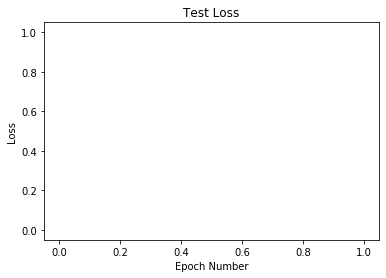

In [0]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Test_loss)


In [0]:
testing = torch.from_numpy(np.vstack(data_test)).shape

In [0]:
model[testing]

In [0]:
str(1)+','+str(2)

'1,2'

In [0]:
yoyo = []
yoyo.append((1,2))

In [0]:
yoyo

[(1, 2)]

In [0]:
yoyo.append((3,4))

In [0]:
tyty = np.array(yoyo)

In [0]:
tyty.shape

(2, 2)

In [0]:
m = nn.Softmax(dim = 1)

In [0]:
input = torch.randn(2, 3)

In [0]:
input


tensor([[-0.0927, -1.1937, -0.3873],
        [-0.2803, -0.6666,  0.5635]])

In [0]:
output = m(input)

In [0]:
output

tensor([[0.7086, 0.2472, 0.0442],
        [0.8346, 0.0762, 0.0892]])

In [0]:
output

tensor([[0.4814, 0.1601, 0.3585],
        [0.2497, 0.1697, 0.5806]])